---
title: "Nielsen's NNDL, ch.1"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In this notebook I'll follow Michael Nielsen's book [Neural Networks and Deep Learning](https://yairmau.com/statistics/#neural-networks-and-deep-learning). I'll make comments if I feel they add something to the original test. If you don't understand everything here, don't worry, you're not supposed to, just refer to the original book if you're interested in the details.

## loading the data

In the [Common Visual Data Foundation's Github](https://github.com/cvdfoundation/mnist), I found the URLs for the MNIST dataset. I will load the data directly into memory using these URLs, without saving them to disk.

In [2]:
#| code-summary: "import libraries"
import os
import io
import gzip
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
# import random

In [5]:
#| code-summary: "define function to load MNIST from web"
def load_mnist_from_web():
    urls = {
        "train_img": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
        "train_lbl": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
        "test_img": "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
        "test_lbl": "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz"
    }

    data_results = {}

    for key, url in urls.items():
        print(f"Fetching {key}...")
        response = requests.get(url)
        response.raise_for_status()
        
        # Wrap the content in BytesIO and decompress in memory
        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
            if "img" in key:
                # Images: offset 16
                data_results[key] = np.frombuffer(f.read(), np.uint8, offset=16)
            else:
                # Labels: offset 8
                data_results[key] = np.frombuffer(f.read(), np.uint8, offset=8)

    # Re-format to Nielsen's expected structure
    def vectorized_result(j):
        e = np.zeros((10, 1))
        e[j] = 1.0
        return e

    training_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in data_results["train_img"].reshape(-1, 784)]
    training_results = [vectorized_result(y) for y in data_results["train_lbl"]]
    training_data = list(zip(training_inputs, training_results))

    test_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in data_results["test_img"].reshape(-1, 784)]
    test_data = list(zip(test_inputs, data_results["test_lbl"]))

    return training_data, test_data

In [6]:
#| code-summary: "load MNIST data into memory"
training_data, test_data = load_mnist_from_web()
print(f"Loaded {len(training_data)} training samples directly into memory.")

Fetching train_img...
Fetching train_lbl...
Fetching test_img...
Fetching test_lbl...
Loaded 60000 training samples directly into memory.


Let's see a few of the images in the training set:

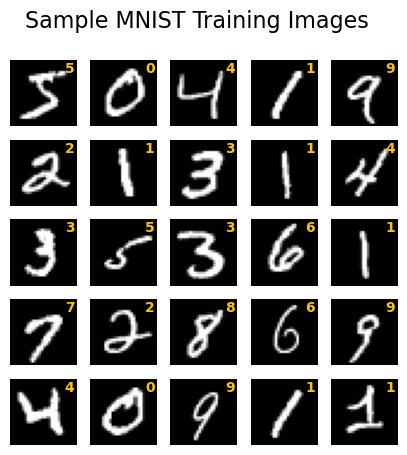

In [7]:
#| code-summary: "see some sample images"
fig, ax = plt.subplots(5, 5, figsize=(5, 5))
ax = ax.flatten()
for i in range(25):
    ax[i].imshow(training_data[i][0].reshape(28, 28), cmap='gray')
    label = np.argmax(training_data[i][1])
    ax[i].text(0.97, 0.97, f"{label}", transform=ax[i].transAxes,
         horizontalalignment='right', verticalalignment='top',
         fontweight="bold", color="xkcd:goldenrod")
    ax[i].axis('off')
fig.suptitle("Sample MNIST Training Images", fontsize=16);

The training set has one-hot encoded labels, while the test set has integer labels. That's perfect for our purposes!

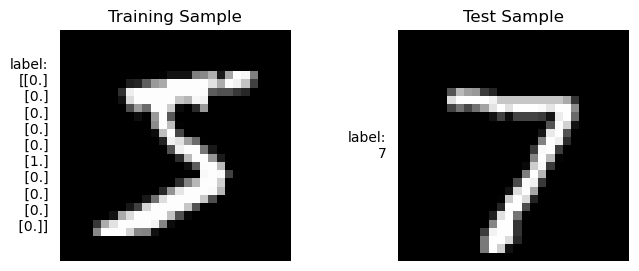

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(training_data[0][0].reshape(28, 28), cmap='gray')
ax[0].text(-0.05, 0.5, "label:\n" + f"{training_data[0][1]}", transform=ax[0].transAxes,
         horizontalalignment='right', verticalalignment='center',)
ax[0].set_title("Training Sample")

ax[1].imshow(test_data[0][0].reshape(28, 28), cmap='gray')
ax[1].text(-0.05, 0.5, "label:\n" + f"{test_data[0][1]}", transform=ax[1].transAxes,
         horizontalalignment='right', verticalalignment='center',)
ax[1].set_title("Test Sample")
ax[0].axis('off')
ax[1].axis('off');

## exercise
<div class="alert alert-info">
**Sigmoid neurons simulating perceptrons, part I**  

Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, $c>0$. Show that the behaviour of the network doesn't change.</div>

$$
\text{perceptron output} =
\begin{cases}
1 & \text{if } z > 0 \\
0 & \text{otherwise}
\end{cases},
$$

where $z=\sum_{i=1}^{n} w_i x_i + b$.

We start with the expression $z=w_i x_i + b$. Multiplying all weights and biases by a positive constant $c$ gives us $c w_i x_i + c b$. We can factor out the constant to get $cz$. Since $c$ is positive, the sign of the expression remains unchanged. Therefore, the output of the perceptron will still be 1 if $cz > 0$ and 0 otherwise, meaning the behavior of the network does not change.

## exercise
<div class="alert alert-info">
**Sigmoid neurons simulating perceptrons, part II**  

Suppose we have the same setup as the last problem --- a network of perceptrons. Suppose also that the overall input to the network of perceptrons has been chosen. We won't need the actual input value, we just need the input to have been fixed. Suppose the weights and biases are such that $w\cdot x+b\neq 0$ for the input $x$ to any particular perceptron in the network. Now replace all the perceptrons in the network by sigmoid neurons, and multiply the weights and biases by a positive constant $c>0$. Show that in the limit as $c\rightarrow \infty$ the behaviour of this network of sigmoid neurons is exactly the same as the network of perceptrons. How can this fail when $w\cdot x+b= 0$ for one of the perceptrons? </div>

Sigmoid function

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Once more, multiplying the weights and biases by $c$ gives us $cz$ as the argument to the sigmoid function:

$$
\sigma(cz) = \frac{1}{1 + e^{-cz}} = \frac{1}{1 + \left(e^{-z}\right)^c}
$$

The factor $e^{-z}<1$ if z is positive, and $e^{-z}>1$ if z is negative. Taking $c$ to infinity raises $e^{-z}$ to the power of infinity, which gives us 0 if $z$ is positive and infinity if $z$ is negative. Therefore, $\sigma(cz)$ approaches 1 if $z$ is positive and 0 if $z$ is negative, which is the same behavior as a perceptron. See the graph below.

In [2]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt

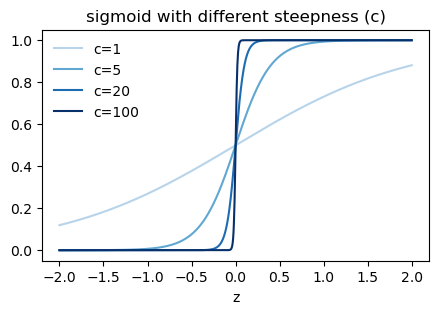

In [20]:
#| code-summary: "sigmoid function with different steepness"
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
z = np.linspace(-2, 2, 1001)
sigma = lambda z: 1 / (1 + np.exp(-z))
c_list = [1, 5, 20, 100]
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(c_list)))
for c, color in zip(c_list, colors):
    ax.plot(z, sigma(c * z), color=color, label=f"c={c}")
ax.legend(loc="upper left", frameon=False)
ax.set(xlabel="z",
       title="sigmoid with different steepness (c)");

 However, if $w\cdot x + b = 0$, then $z=0$ and $\sigma(cz) = \sigma(0) = 0.5$ for all values of $c$, which does not match the behavior of a perceptron, which would output 0 in this case.

## exercise
<div class="alert alert-info">
There is a way of determining the bitwise representation of a digit by adding an extra layer to the three-layer network above. The extra layer converts the output from the previous layer into a binary representation, as illustrated in the figure below. Find a set of weights and biases for the new output layer. Assume that the first 3 layers of neurons are such that the correct output in the third layer (i.e., the old output layer) has activation at least 0.99, and incorrect outputs have activation less than 0.01. </div>

Instead of thinking what are the weights and biases for each of the 4 output neurons, we can think of the weights and biases for each of the 10 neurons in the previous layer. We do that by writing the binary representation of the output digit, for example:



In [ ]:
#| code-fold: false
for i in range(10):
    print(f"{i} = {i:04b}")

0 = 0000
1 = 0001
2 = 0010
3 = 0011
4 = 0100
5 = 0101
6 = 0110
7 = 0111
8 = 1000
9 = 1001


The first column corresponds to the weights for the first output neuron, the second column corresponds to the weights for the second output neuron, and so on. In order to get activation for $z=1$ and no activation for $z=0$, we can shift the sigmoid function to the right by setting the bias to -0.5. This way, if the input is 1, we get $z=1-0.5=0.5$ which gives us an activation of $\sigma(0.5) \approx 0.62$, and if the input is 0, we get $z=0-0.5=-0.5$ which gives us an activation of $\sigma(-0.5) \approx 0.38$. This is enought to make it work, but the constrast between "on" and "off" is not very high. We can increase the contrast by multiplying the weights and biases by a positive constant $c$, as we saw in the previous exercises. For example, if we set $c=10$, then for an input of 1 we get $z=10*1-10*0.5=5$ which gives us an activation of $\sigma(5) \approx 0.993$, and for an input of 0 we get $z=10*0-10*0.5=-5$ which gives us an activation of $\sigma(-5) \approx 0.007$.


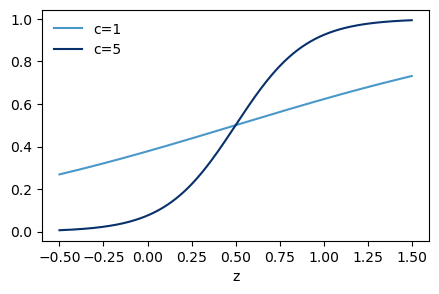

In [22]:
#| code-summary: "sigmoid function"
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
z = np.linspace(-0.5, 1.5, 1001)
sigma = lambda z: 1 / (1 + np.exp(-z))
c_list = [1, 5]
colors = plt.cm.Blues(np.linspace(0.6, 1.0, len(c_list)))
for c, color in zip(c_list, colors):
    ax.plot(z, sigma(c * (z-0.5)), color=color, label=f"c={c}")
ax.legend(loc="upper left", frameon=False)
ax.set(xlabel="z",
    #    title="sigmoid with different steepness (c)"
       );

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc

# Essential for Quarto static HTML embedding
rc('animation', html='jshtml')

def sigma(x):
    return 1 / (1 + np.exp(-x))

# Constants
N = 10
w = np.array([[int(c) for c in f"{num:04b}"[::-1]] for num in range(N)])
b = -0.5 * np.ones(4)
ms = 20

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

def update(frame):
    ax.clear()
    neuron_on = frame
    
    # Input state
    x = np.zeros(N) + 0.01
    x[neuron_on] = 0.99
    
    # Calculation
    z = np.dot(w.T, x) + b
    output = sigma(10 * z)
    
    # Draw connections (Weights)
    for i, row in enumerate(w):
        color = "xkcd:vermillion" if i == neuron_on else "gray"
        for j, val in enumerate(row):
            alpha = 1.0 if val == 1 else 0.2
            ax.plot([0, 1], [N - i, (4 - j) + 3], color=color, lw=2, alpha=alpha)

    # Draw input neurons (LHS)
    for i in range(N):
        mfc = "xkcd:vermillion" if x[i] > 0.5 else "white"
        ax.plot([0], [N - i], ls='None', marker='o', mfc=mfc, 
                mec="xkcd:vermillion", markersize=ms)
        ax.text(-0.1, N - i, f"{i}", va='center', ha='right', fontsize=14) 

    # Draw output neurons (RHS)
    for i in range(4):
        shade = str(1 - output[i]) # Grayscale string for mfc
        ax.plot([1], [(4 - i) + 3], ls='None', marker='o', mfc=shade, 
                mec="black", markersize=ms)
        ax.text(1 + 0.1, (4 - i) + 3, f"{2**i}", va='center', ha='left', fontsize=14)

    ax.text(0, 0, "old output layer", va="top", ha="center", fontsize=14)
    ax.text(1, 0, "new output layer", va="top", ha="center", fontsize=14)

    ax.set(xlim=(-0.5, 1.5), ylim=(0, N + 1), xticks=[], yticks=[])
    ax.set_title(f"Active Neuron: {neuron_on}")
    ax.axis('off')

# Create animation: 10 frames (0 through 9)
anim = FuncAnimation(fig, update, frames=range(N), interval=500)

plt.close(fig)  # Prevents the static plot from being captured
# In a Jupyter notebook, simply calling 'anim' will display the JS player
anim

## exercise
> Indeed, there's even a sense in which gradient descent is the optimal strategy for searching for a minimum. Let's suppose that we're trying to make a move $\Delta v$ in position so as to decrease $C$ as much as possible. This is equivalent to minimizing $\Delta C≈\nabla C\cdot\Delta v$. We'll constrain the size of the move so that $\Vert \Delta v\Vert=\epsilon$ for some small fixed $\epsilon>0$. In other words, we want a move that is a small step of a fixed size, and we're trying to find the movement direction which decreases C as much as possible. It can be proved that the choice of $\Delta v$ which minimizes $\nabla C\cdot\Delta v$ is $\Delta v=−\eta\nabla C$, where $\eta=\epsilon/\Vert\nabla C\Vert$ is determined by the size constraint $\Vert\Delta v\Vert=\epsilon$. So gradient descent can be viewed as a way of taking small steps in the direction which does the most to immediately decrease C.

<div class="alert alert-info">
Prove the assertion of the last paragraph. Hint: If you're not already familiar with the [Cauchy-Schwarz inequality](http://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality), you may find it helpful to familiarize yourself with it. </div>

The Cauchy-Schwarz inequality states that for any vectors $a$ and $b$, we have:
$$
|a \cdot b| \leq \Vert a \Vert \Vert b \Vert
$$

with equality if and only if $a$ and $b$ are linearly dependent. In our case, we want to minimize $\nabla C \cdot \Delta v$ subject to $\Vert \Delta v \Vert = \epsilon$. We can rewrite this as:

$$
\nabla C \cdot \Delta v = \Vert \nabla C \Vert \Vert \Delta v \Vert \cos(\theta)
$$

where $\theta$ is the angle between $\nabla C$ and $\Delta v$. To minimize this expression, we want the smallest value of $\cos(\theta)$, which is $-1$ when $\theta = \pi$, meaning that $\Delta v$ is in the opposite direction of $\nabla C$. Therefore, we have:
$$
\Delta v = -\eta \nabla C
$$
where $\eta$ is a positive constant that ensures $\Vert \Delta v \Vert = \epsilon$. We can find $\eta$ by solving for it in the constraint:
$$
\Vert \Delta v \Vert = \Vert -\eta \nabla C \Vert = \eta \Vert \nabla C \Vert = \epsilon
$$
which gives us:
$$
\eta = \frac{\epsilon}{\Vert \nabla C \Vert},
$$
therefore
$$
\Delta v = -\frac{\epsilon}{\Vert \nabla C \Vert} \nabla C.
$$

The step in the parameter space is in the opposite direction of the unitary vector of the gradient, and its size is $\epsilon$, which is the maximum allowed step size. This shows that gradient descent is the optimal strategy for searching for a minimum under the given constraints.


## exercise

<div class="alert alert-info">
I explained gradient descent when C is a function of two variables, and when it's a function of more than two variables. What happens when C is a function of just one variable? Can you provide a geometric interpretation of what gradient descent is doing in the one-dimensional case? </div>

The gradient descent algorithm in the one-dimensional case is essentially performing a simple iterative process to find the local minimum of a function. In this case, the "gradient" is just the derivative of the function with respect to the variable.

## exercise

<div class="alert alert-info">
An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, $x$, we update our weights and biases according to the rules $w_k\rightarrow w'_k=w_k−\eta \partial C_x/\partial w_k$ and $b_l\rightarrow b'_l=b_l−\eta\partial C_x/\partial b_l$. Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20. </div>

Advantage: We have the hope of learning which weights and biases in our network are most associated with a given training input, which can be useful for interpretability and understanding the model's behavior.

Disadvantage: The path in the parameter space will by so much noisier than with a mini-batch size of 20, which can make it harder to converge to a good minimum.

## the code

I've made a few updates to the original code in the book:

1. I've added ReLU as the default activation function, but you can choose sigmoid if you want.
2. I've vectorized the backpropagation algorithm to handle mini-batches efficiently, which should speed up training significantly.
3. I added a progress bar to the training loop using `tqdm` to visualize the training progress.
4. You can quit training early by pressing `Ctrl+C`, the model will keep the weights without raising an error.

In [ ]:
def sigmoid(z):
    """The sigmoid function, JIT-compiled for speed."""
    return 1.0 / (1.0 + np.exp(-z))

def relu(z):
    """The ReLU function, JIT-compiled for speed."""
    return np.maximum(0, z)

def sigmoid_prime(z):
    """Derivative of the sigmoid function, JIT-compiled for speed."""
    s = 1.0 / (1.0 + np.exp(-z))
    return s * (1 - s)

def relu_prime(z):
    """Derivative of the ReLU function, JIT-compiled for speed."""
    return np.where(z > 0, 1.0, 0.0)

class Network(object):

    def __init__(self, layer_sizes, activation='relu'):
        self.num_layers = len(layer_sizes)
        self.sizes = layer_sizes
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.activation = activation
        if activation == 'relu':
            self.activation_func = relu
            self.activation_prime = relu_prime
        elif activation == 'sigmoid':
            self.activation_func = sigmoid
            self.activation_prime = sigmoid_prime
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'sigmoid'.")

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            a = self.activation_func(z)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """Train using vectorized mini-batch stochastic gradient descent."""
        if test_data: 
            n_test = len(test_data)
        n = len(training_data)

        try:
            for j in range(epochs):
                random.shuffle(training_data)
                mini_batches = [
                    training_data[k:k+mini_batch_size]
                    for k in range(0, n, mini_batch_size)]
                
                # ASCII Progress bar with Epoch X/Y description
                pbar = tqdm(mini_batches, desc=f"Epoch {j+1}/{epochs}", leave=True)
                
                for mini_batch in pbar:
                    self.update_mini_batch(mini_batch, eta)
                
                if test_data:
                    successes = self.evaluate(test_data)
                    print(f"Epoch {j+1}/{epochs}: {successes} / {n_test}")
                else:
                    print(f"Epoch {j+1}/{epochs} complete")
                    
        except KeyboardInterrupt:
            if 'pbar' in locals():
                pbar.close()
            print("\n\nTraining interrupted by user. Weights preserved.")

    def update_mini_batch(self, mini_batch, eta):
        """Update weights/biases using vectorized backpropagation."""
        # Vectorization: stack all inputs x and labels y into matrices
        # X shape: (features, batch_size), Y shape: (outputs, batch_size)
        x_batch = np.column_stack([data[0] for data in mini_batch])
        y_batch = np.column_stack([data[1] for data in mini_batch])
        
        nabla_b, nabla_w = self.backprop(x_batch, y_batch)
        
        m = len(mini_batch)
        self.weights = [w - (eta / m) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / m) * nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Vectorized backpropagation over a whole mini-batch."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Feedforward
        activation = x
        activations = [x] 
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b # Broadcasting adds b to each column
            zs.append(z)
            activation = self.activation_func(z)
            activations.append(activation)
            
        # Backward pass
        # Error delta is a matrix of shape (layer_size, batch_size)
        delta = (activations[-1] - y) * self.activation_prime(zs[-1])
        
        # Sum errors across the batch for biases; dot product handles weights
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.activation_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of correct classifications."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

In [12]:
net = Network(layer_sizes=[784, 30, 10])
net.SGD(training_data=training_data,
        epochs=8,
        mini_batch_size=10,
        eta=3.0,
        test_data=test_data)

Epoch 1/8:   0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 1/8: 100%|██████████| 6000/6000 [00:04<00:00, 1252.79it/s]


Epoch 1/8: 980 / 10000


Epoch 2/8: 100%|██████████| 6000/6000 [00:02<00:00, 2209.63it/s]


Epoch 2/8: 980 / 10000


Epoch 3/8: 100%|██████████| 6000/6000 [00:03<00:00, 1949.01it/s]


Epoch 3/8: 980 / 10000


Epoch 4/8: 100%|██████████| 6000/6000 [00:02<00:00, 2104.76it/s]


Epoch 4/8: 980 / 10000


Epoch 5/8: 100%|██████████| 6000/6000 [00:02<00:00, 2175.81it/s]


Epoch 5/8: 980 / 10000


Epoch 6/8: 100%|██████████| 6000/6000 [00:02<00:00, 2148.77it/s]


Epoch 6/8: 980 / 10000


Epoch 7/8: 100%|██████████| 6000/6000 [00:02<00:00, 2207.82it/s]


Epoch 7/8: 980 / 10000


Epoch 8/8: 100%|██████████| 6000/6000 [00:03<00:00, 1899.05it/s]


Epoch 8/8: 980 / 10000


In [100]:
net.weights[1].shape

(10, 30)